<a href="https://colab.research.google.com/github/bfatmab/Sale_Forcasting_With_AI/blob/main/Sale_Forcasting_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import os

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
# Adım 1: Veri Setini Yükleme
data = pd.read_csv('amazon.csv')

<ipython-input-106-fc38145416dd>:13: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('amazon.csv')


In [108]:
# İlk 10 veriyi getirir
data.head(10)


,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN
5,5,404-1490984-4578765,04-30-22,Shipped,Amazon,Amazon.in,Expedited,SET264,SET264-KR-NP-XL,Set,...,INR,824.00,GHAZIABAD,UTTAR PRADESH,201102.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN,NaN
6,6,408-5748499-6859555,04-30-22,Shipped,Amazon,Amazon.in,Expedited,J0095,J0095-SET-L,Set,...,INR,653.00,CHANDIGARH,CHANDIGARH,160036.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN,NaN
7,7,406-7807733-3785945,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3405,JNE3405-KR-S,kurta,...,INR,399.00,HYDERABAD,TELANGANA,500032.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
8,8,407-5443024-5233168,04-30-22,Cancelled,Amazon,Amazon.in,Expedited,SET200,SET200-KR-NP-A-XXXL,Set,...,NaN,NaN,HYDERABAD,TELANGANA,500008.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN,NaN
9,9,402-4393761-0311520,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3461,JNE3461-KR-XXL,kurta,...,INR,363.00,Chennai,TAMIL NADU,600041.0,IN,NaN,False,NaN,NaN


In [109]:
# Satır ve sütun sayısnı verir
data.shape

(128975, 24)

In [110]:
sale_channel='Sales Channel'
ship_service_level='ship-service-level'
courier_status='Courier Status'
un='Unnamed: 22'

columns=['index','Status','Fulfilment',ship_service_level,'Style','SKU','Size','ASIN',courier_status,'Qty','currency','ship-city','ship-state','ship-state','ship-postal-code','ship-country','promotion-ids','B2B','fulfilled-by',un]
data=data.drop(columns,axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Order ID        128975 non-null  object 
 1   Date            128975 non-null  object 
 2   Sales Channel   128975 non-null  object 
 3   Category        128975 non-null  object 
 4   Amount          121180 non-null  float64
dtypes: float64(1), object(4)
memory usage: 4.9+ MB


Date kolonunun tipini değiştirdik

In [111]:
data['Date'] = pd.to_datetime(data['Date'])

bir veri çerçevesindeki tarih sütununu aylık döneme çevirerek ve bu aylara göre satışları toplamlayarak aylık satışları hesaplar.

In [112]:
data['Date']= data['Date'].dt.to_period("D") 
dayly_sales=data.groupby('Date').sum().reset_index()

<ipython-input-112-37e8fdaf3b04>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dayly_sales=data.groupby('Date').sum().reset_index()


In [113]:
dayly_sales['Date']=dayly_sales['Date'].dt.to_timestamp()

In [114]:
dayly_sales.head(10)

,Date,Amount
0,2022-03-31,101683.85
1,2022-04-01,865478.60
2,2022-04-02,913101.53
3,2022-04-03,1011763.38
4,2022-04-04,882059.17
5,2022-04-05,950544.05
6,2022-04-06,886985.26
7,2022-04-07,909899.35
8,2022-04-08,1018617.61
9,2022-04-09,972076.48


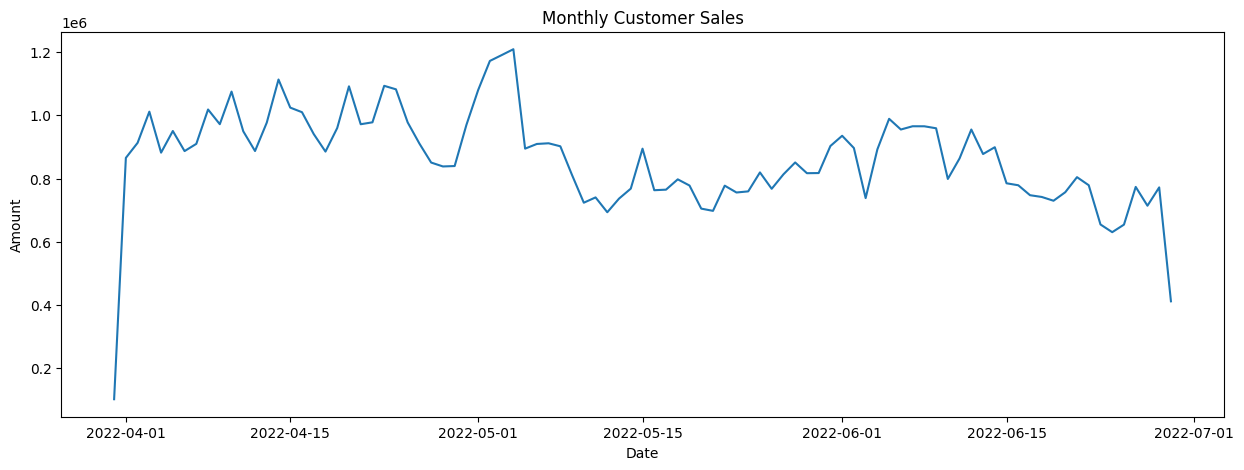

In [115]:
 plt.figure(figsize=(15,5))
 plt.plot(dayly_sales['Date'],dayly_sales['Amount'])
 plt.xlabel("Date")
 plt.ylabel("Amount")
 plt.title("Monthly Customer Sales")
 plt.show()